In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import numpy as np
import networkx as nx
def has_only_letters_and_space(text):
    text = remove_stop_symbols(text)
    
    pattern = r'^[A-Za-z\s]+$'
    return re.match(pattern, text) is not None


def filter_words_boxes(G):
    nodes_to_remove = []
    for node in G:
        w = G.nodes[node]['text'].lower()
        w = w.lower()
        #w = ''.join([char for char in w if not char.isdigit()])
        
        if not has_only_letters_and_space(w):
            nodes_to_remove.append(node)
            continue
        
        w = w.strip()
        #if len(w) == len(''.join([i for i in w if not i.isdigit()])):
        
        if len(w)<=3:
            nodes_to_remove.append(node)
            continue
            
        if len(w.split(' '))>=4:
            nodes_to_remove.append(node)
            
        #neighbor to not word
        not_word_exists = False
        for neighbor in G.neighbors(node):
            if G.nodes[neighbor]['text']!=G.nodes[neighbor]['masked_text']:
                not_word_exists = True
                break
            
        if not not_word_exists:
            nodes_to_remove.append(node)
            
    if nodes_to_remove:
        G.remove_nodes_from(nodes_to_remove)
                

def text_similarity(words1,words2):
    """Calculate the similarity between two sets of words based on the Jaccard index."""
    
    words1_set = set(words1)
    words2_set = set(words2)
     
    shared = words1_set & words2_set
    union = words1_set | words2_set
    
    if not union:
        return shared, union, 0

    similarity = round(len(shared) / len(union), 2)
    
    return shared, union, similarity


def images_similarity(source_G,target_G, pairwise_distance, threshold=5):
    """Calculate the similarity between two images based on the number of matched boxes."""

    found_boxes = []
    for ix in range(len(source_G)):
        matched_box = find_target_node_by_text(ix, 
                            source_G,
                            target_G,
                            pairwise_distance,
                            threshold=threshold
                            )
            
        if matched_box is not None:
            found_boxes.append(matched_box)
    
    if not found_boxes:
        return 0, 0
    
    num_found_boxes = len(found_boxes)

    return num_found_boxes, round(2*num_found_boxes/(len(source_G)+len(target_G)),2)

from PIL import Image
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [3]:
from sentence_transformers import SentenceTransformer, util
text_embedder_core = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
def text_to_embedding(text):
    #if find_word(text) or find_words(text):
    return text_embedder_core.encode(text, convert_to_tensor=False)

In [450]:
from doc2graph.src.data.image_utils import get_word_boxes, draw_graph, file_to_images, normalize_box
from doc2graph.src.data.graph_utils import area, get_all_simple_paths, get_containing_box, create_graph, get_all_egos, same_graphs, calc_text_embedding, get_all_subgraphs, features_dist, find_target_node_by_text
from doc2graph.src.data.find_items import text_to_mask,remove_stop_symbols, find_codes,has_digits

from sklearn.metrics import pairwise_distances


In [663]:
source_file = "data/b2f42472-7b07-44ed-9ef7-e7cb49b6b643.jpeg"
target_file = "data/1685484224508_0455103c-074a-42c5-bc05-aa534505d658_RecordtransferACH052623.pdf"


In [580]:
source_file = "data/1e43f756-82ec-48f5-aaa7-165f4bea3ad5.pdf"
target_file = "data/bdc8c660-9027-4cda-8750-1be3b1bc9529.pdf"


In [664]:
source_word_boxes = get_word_boxes(source_file, 'https://xiqo6syt8a.execute-api.us-east-1.amazonaws.com/paddleocr_textboxes/calc_embedding')
target_word_boxes = get_word_boxes(target_file, 'https://xiqo6syt8a.execute-api.us-east-1.amazonaws.com/paddleocr_textboxes/calc_embedding')

In [665]:
source_image = file_to_images(source_file)[0]
target_image = file_to_images(target_file)[0]
source_image_size = source_image.size
target_image_size = target_image.size

In [666]:
source_words = [remove_stop_symbols(w) for w in source_word_boxes['words']]
target_words = [remove_stop_symbols(w) for w in target_word_boxes['words']]

In [667]:
source_graph = create_graph(source_words, source_word_boxes['boxes'])
target_graph = create_graph(target_words, target_word_boxes['boxes'])

In [668]:
calc_text_embedding(source_graph, text_to_embedding=None, text_to_mask = text_to_mask)
calc_text_embedding(target_graph, text_to_embedding=None, text_to_mask = text_to_mask)


In [669]:
filter_words_boxes(source_graph)
filter_words_boxes(target_graph)

source_graph = create_graph([source_graph.nodes[node]['text'] for node in source_graph], [source_graph.nodes[node]['box'] for node in source_graph])
target_graph = create_graph([target_graph.nodes[node]['text'] for node in target_graph], [target_graph.nodes[node]['box'] for node in target_graph])

In [670]:
source_containing_area = area(normalize_box(get_containing_box(source_graph), source_image_size[0], source_image_size[1]))
target_containing_area = area(normalize_box(get_containing_box(target_graph), target_image_size[0], target_image_size[1]))
source_containing_area, target_containing_area

(705364, 776736)

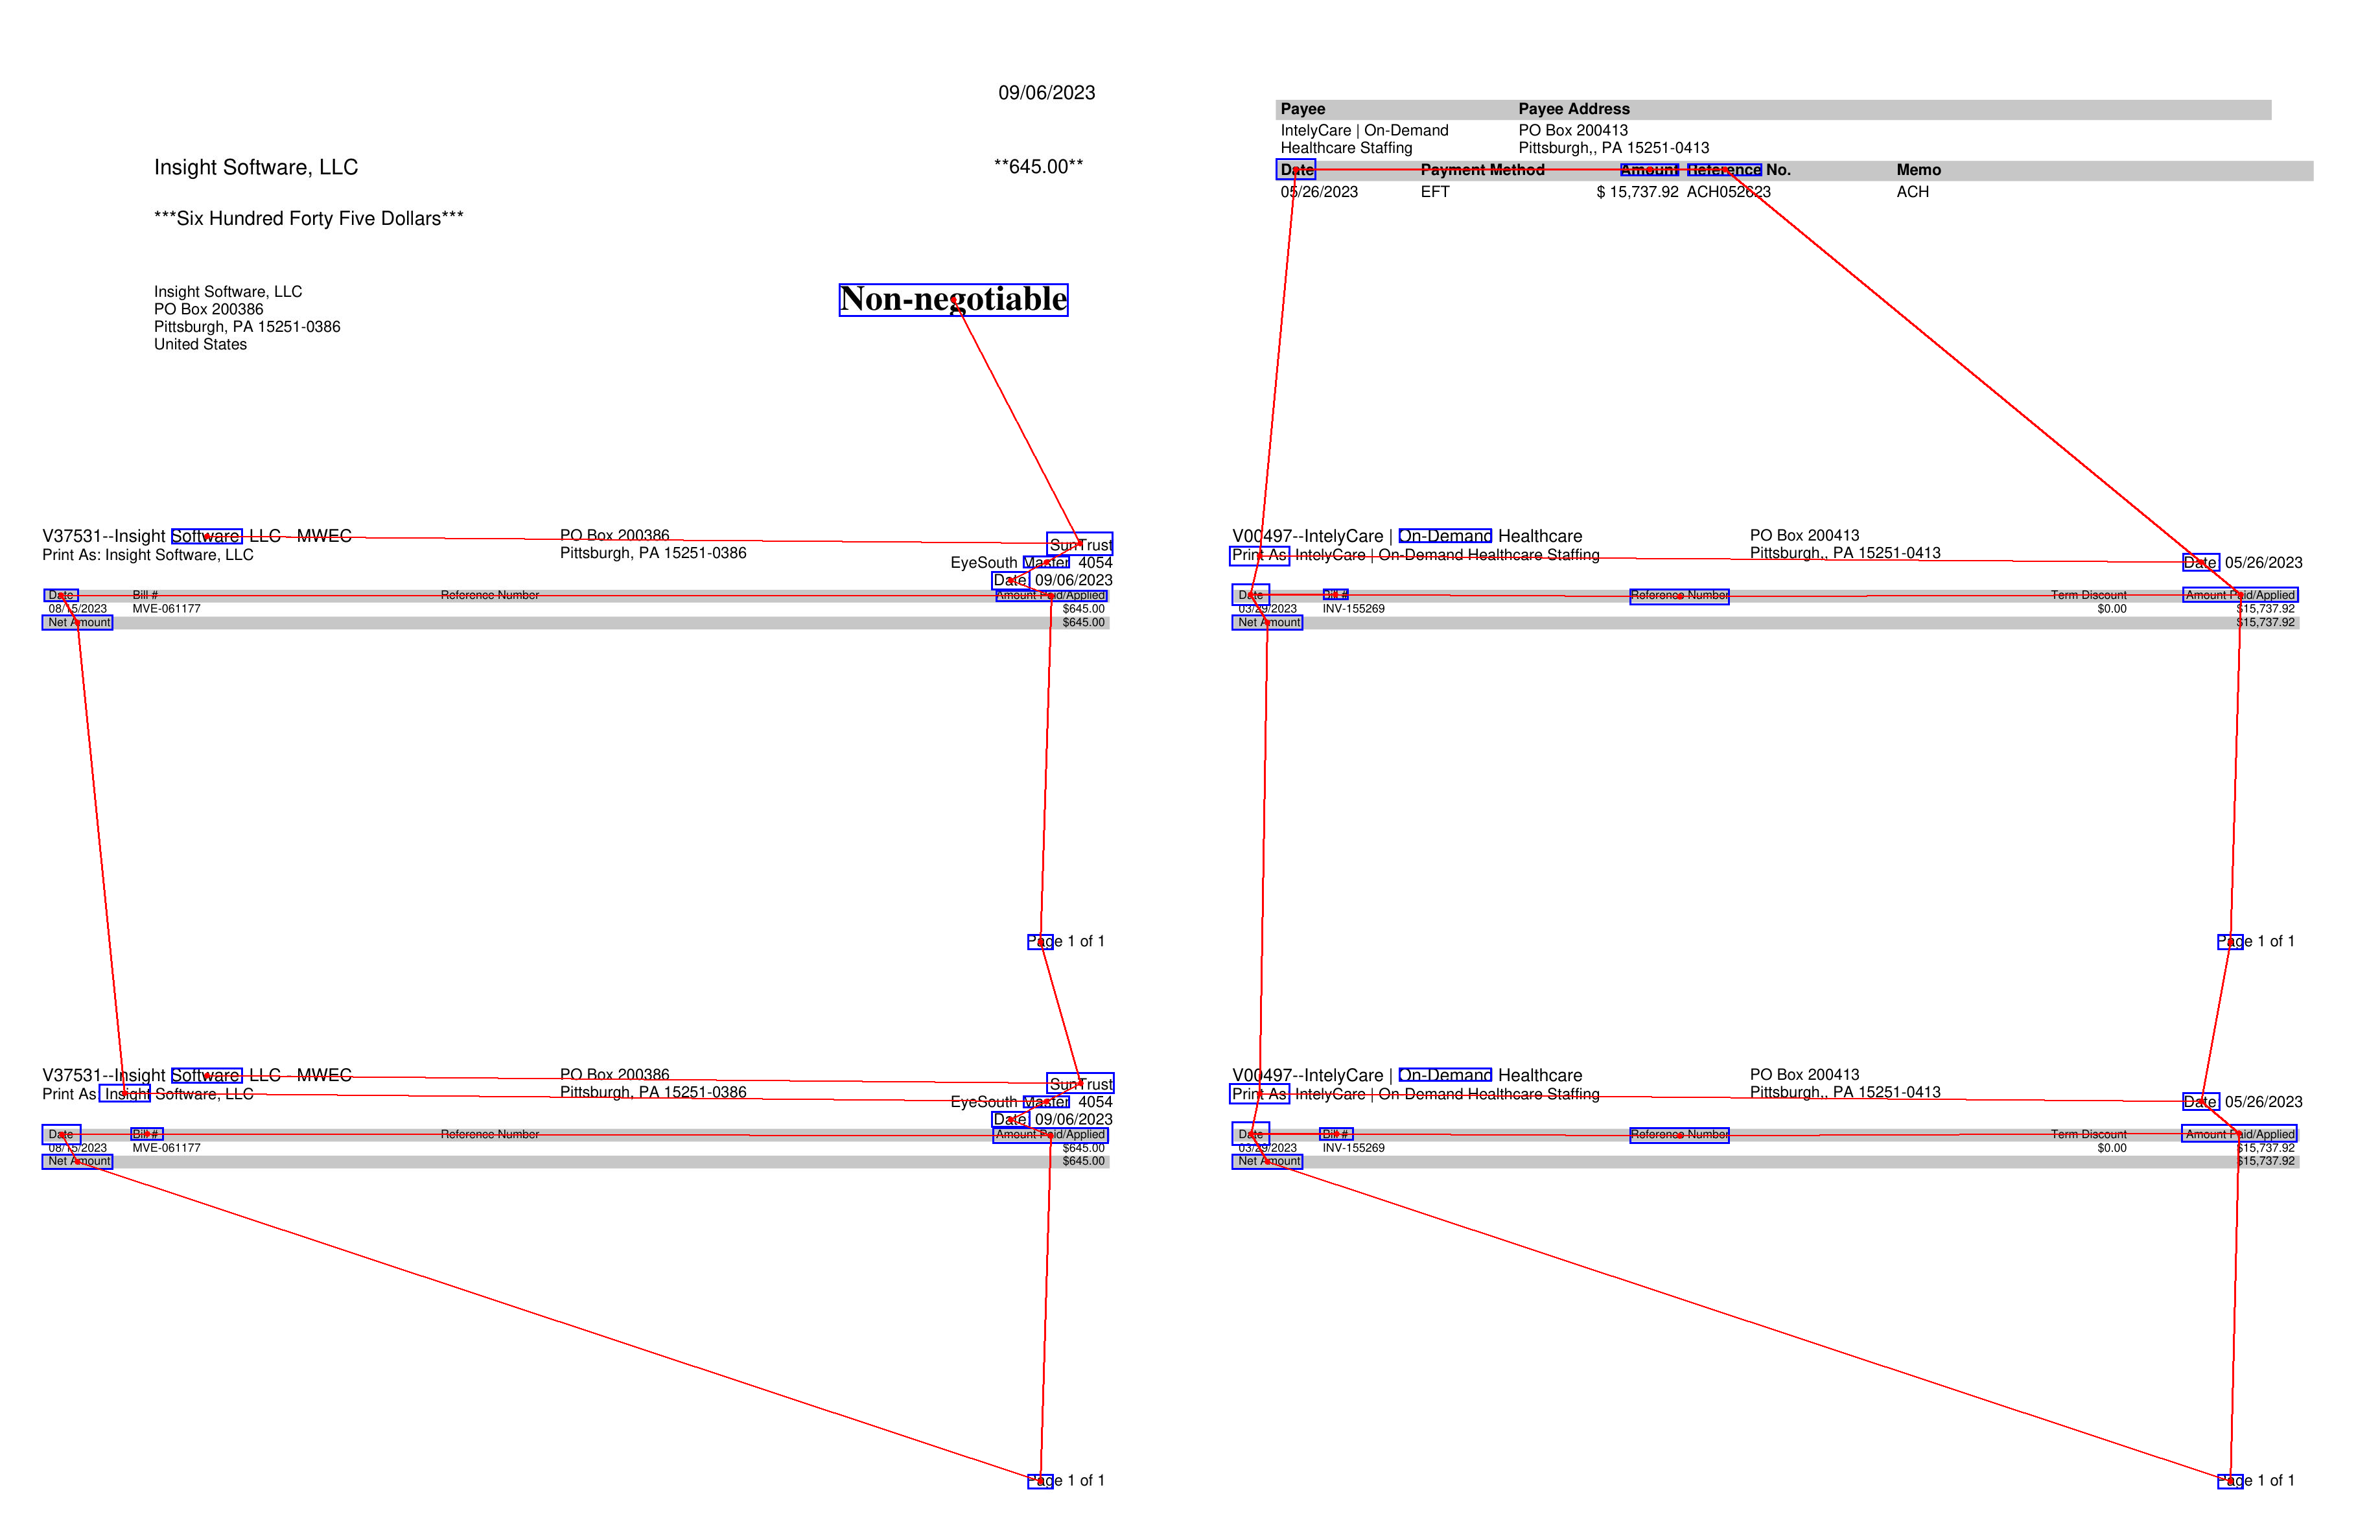

In [671]:
im_t = target_image.copy()
draw_graph(im_t, target_graph,nodes=None)
im_s = source_image.copy()
draw_graph(im_s, source_graph,nodes=None)
get_concat_h(im_s, im_t)
#im_s


In [672]:
source_words_filtered = [source_graph.nodes[node]['text'] for node in source_graph]
target_words_filtered = [target_graph.nodes[node]['text'] for node in target_graph]
shared_words, _, text_similarity_score = text_similarity(source_words_filtered, target_words_filtered)
shared_words = list(shared_words)
text_similarity_score     

0.33

In [673]:
source_words_shared = [w for w in source_words_filtered if w in shared_words]
target_words_shared = [w for w in target_words_filtered if w in shared_words]
source_boxes_shared = [source_graph.nodes[node]['box'] for node in source_graph if source_graph.nodes[node]['text'] in shared_words]
target_boxes_shared = [target_graph.nodes[node]['box'] for node in target_graph if target_graph.nodes[node]['text'] in shared_words]

In [674]:
source_graph_shared = create_graph(source_words_shared, source_boxes_shared)#.to_undirected()
target_graph_shared = create_graph(target_words_shared, target_boxes_shared)#.to_undirected()

calc_text_embedding(source_graph_shared, text_to_embedding=None, text_to_mask = text_to_mask)
calc_text_embedding(target_graph_shared, text_to_embedding=None, text_to_mask = text_to_mask)

In [532]:
# for n in source_graph_shared:
#     source_graph_shared.nodes[n]['shared_index'] = shared_words.index(source_graph_shared.nodes[n]['masked_text'])
# for n in target_graph_shared:
#     target_graph_shared.nodes[n]['shared_index'] = shared_words.index(target_graph_shared.nodes[n]['masked_text'])

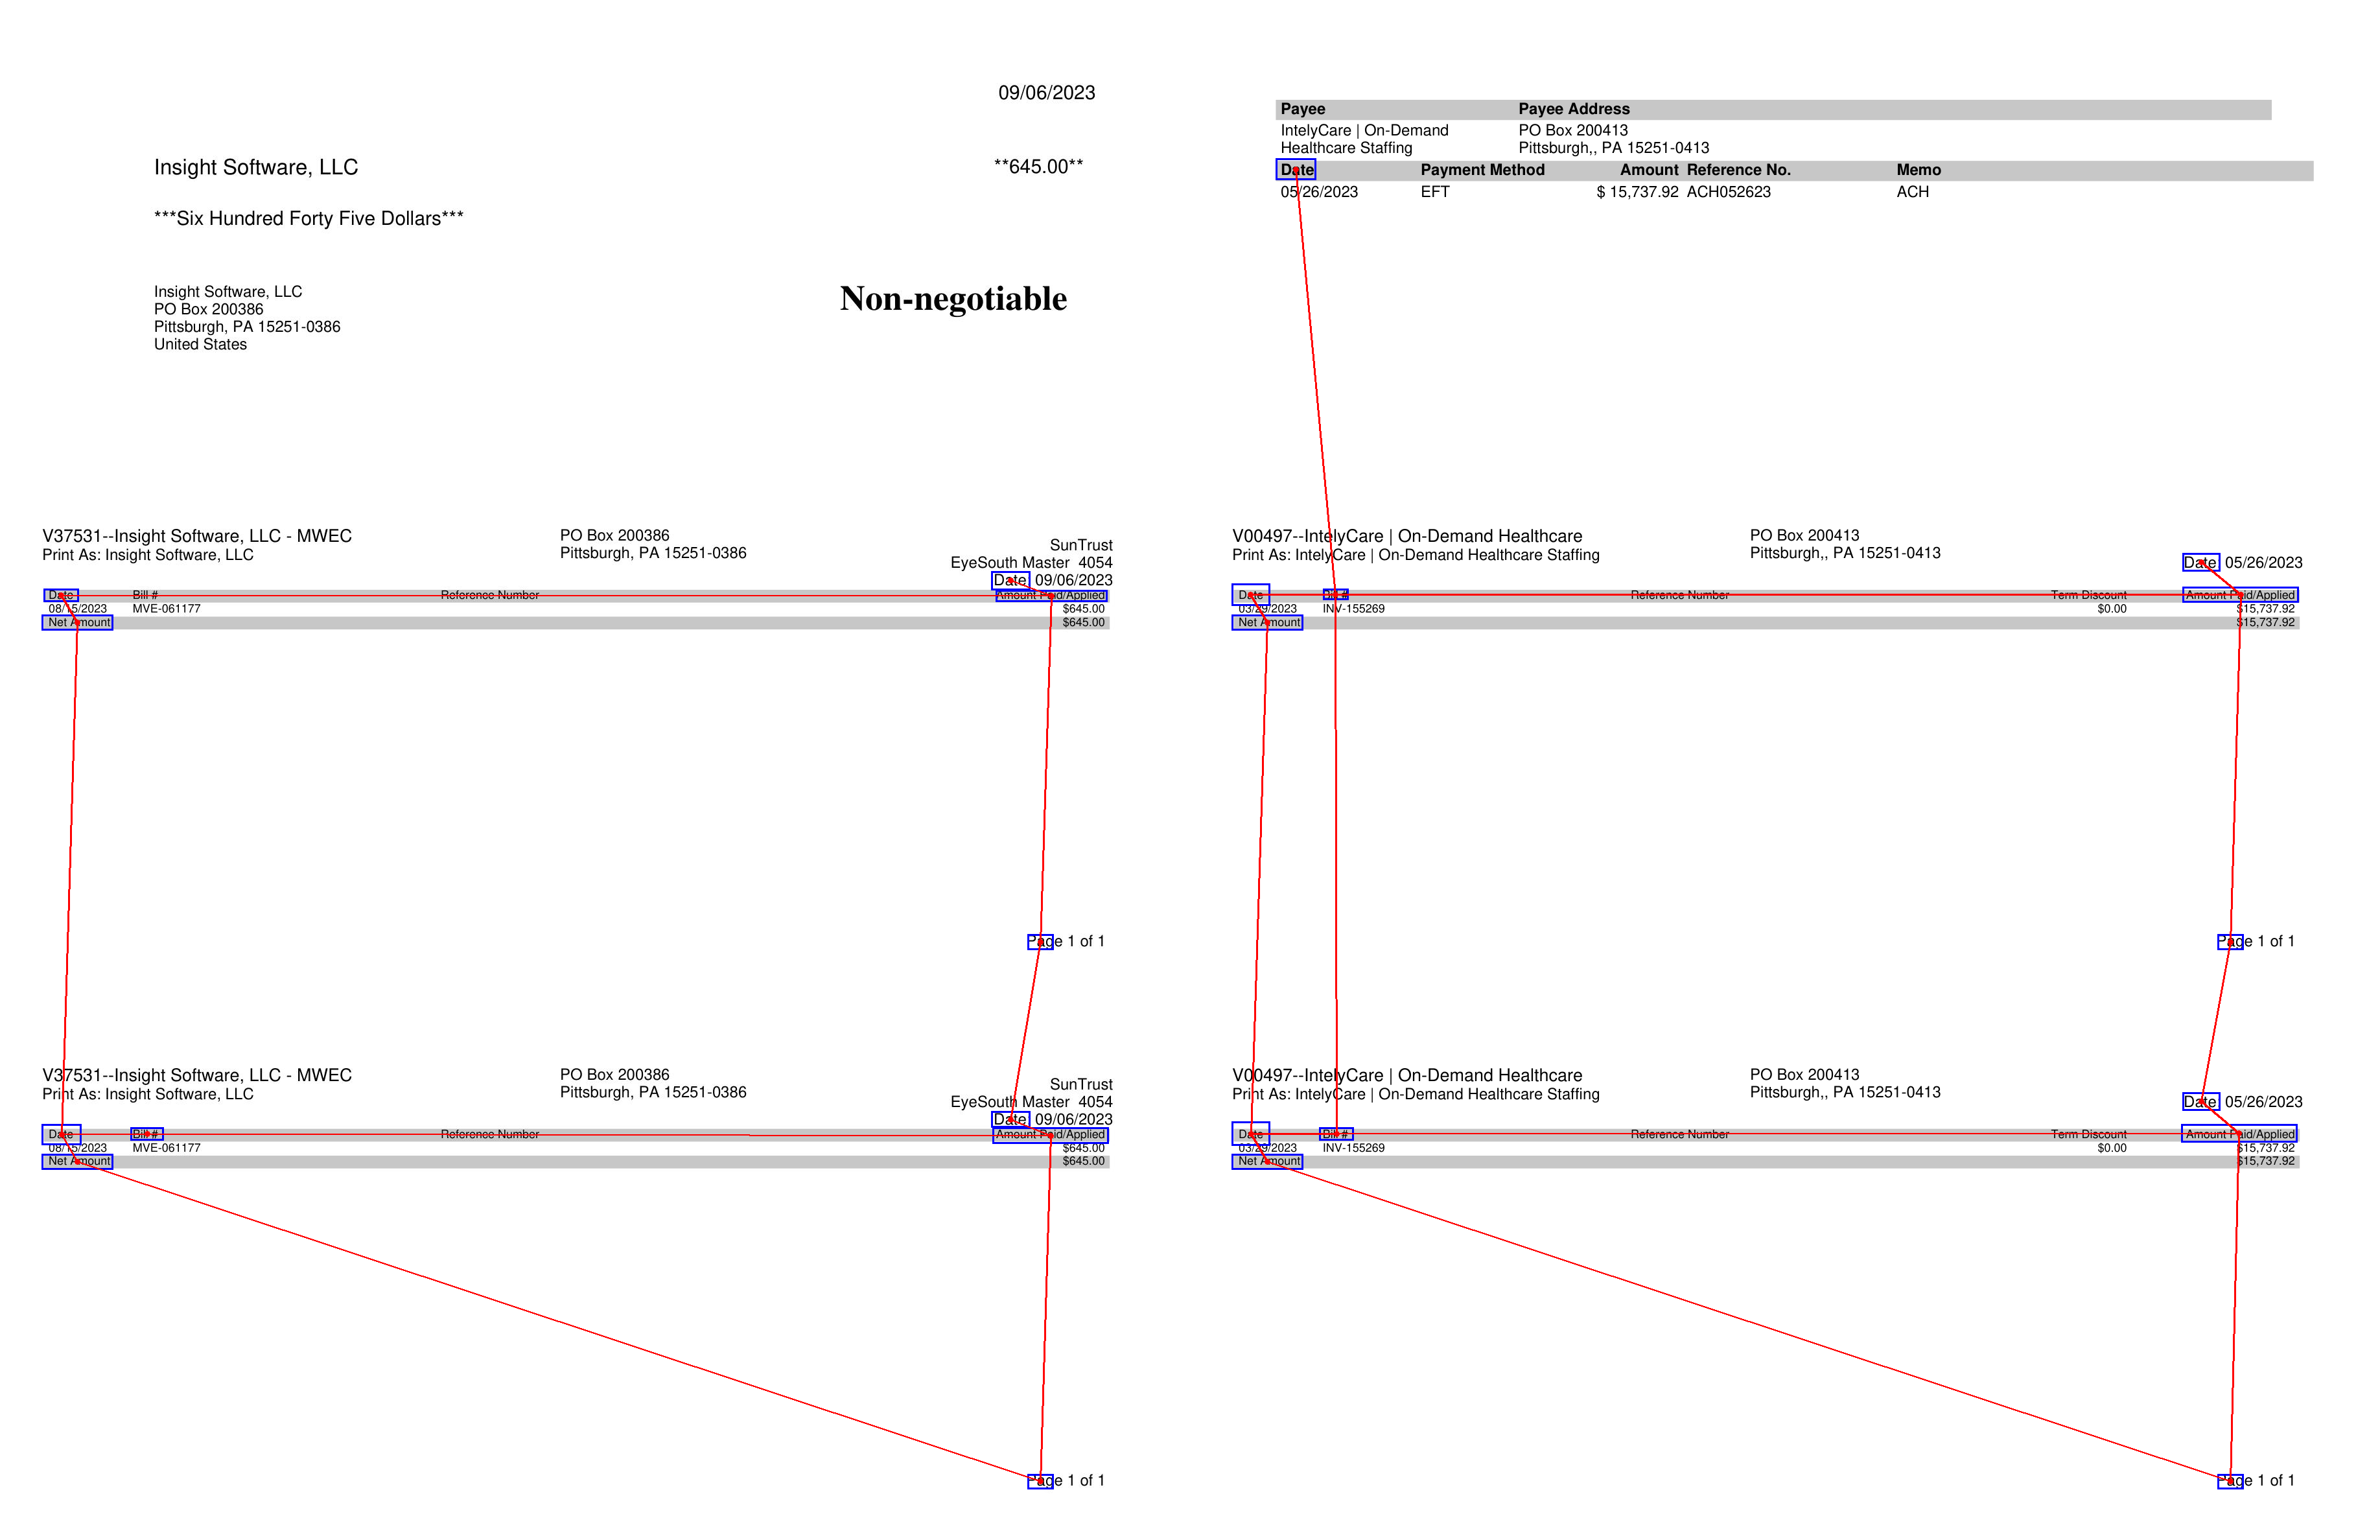

In [675]:
im_s = source_image.copy()
draw_graph(im_s, source_graph_shared,nodes=None)
im_t = target_image.copy()
draw_graph(im_t, target_graph_shared,nodes=None)
get_concat_h(im_s, im_t)
#im_s

In [676]:
all_subgraphs_source = get_all_subgraphs(source_graph_shared.to_undirected(), min_length = len(source_graph_shared)/2)
all_subgraphs_target = get_all_subgraphs(target_graph_shared.to_undirected(), min_length = len(target_graph_shared)/2)
len(all_subgraphs_target)

153

In [677]:
def matched(source_graph_matched, target_graph_matched):
    source_containing_area_matched = area(normalize_box(get_containing_box(source_graph_matched), source_image_size[0], source_image_size[1]))
    target_containing_area_matched = area(normalize_box(get_containing_box(target_graph_matched), target_image_size[0], target_image_size[1]))

    #print(ix, source_containing_area_matched, target_containing_area_matched)

    shared_area_diff = abs(source_containing_area_matched/target_containing_area_matched-1)
    
    print('shared_area_diff' , shared_area_diff)
    
    if shared_area_diff>0.2:
        return False
    
    # source_area_diff = abs(source_containing_area_matched/source_containing_area-1)
    # target_area_diff = abs(target_containing_area_matched/target_containing_area-1)
    
    # print(source_area_diff, target_area_diff)
    # if source_area_diff>0.2:
    #     return False
    
    
    # if target_area_diff>0.2:
    #     return False
    
    return True

In [683]:
matched_source=[]
matched_target=[]

match_found=False
for source_nodes in all_subgraphs_source:
    # if match_found:
    #     break
    source_nodes = set(source_nodes)
    for target_nodes in all_subgraphs_target:
        target_nodes = set(target_nodes)
        if len(source_nodes)!=len(target_nodes):
            continue
        
        added = False
        for i,m in enumerate(matched_source):
            if source_nodes.issubset(m):
                added = True
                break
            
        if not added:    
            source_graph_matched = source_graph_shared.subgraph(source_nodes)
            target_graph_matched = target_graph_shared.subgraph(target_nodes)
            if same_graphs(source_graph_matched,target_graph_matched):
                match_found = matched(source_graph_matched, target_graph_matched)
                if match_found:
                    # added = False
                    # for i,m in enumerate(matched_source):
                    #     if source_nodes.intersection(m):
                    #         matched_source[i] = source_nodes | matched_source[i]
                    #         matched_target[i] = target_nodes | matched_target[i]
                    #         added = True
                    #         break
                    if not added:
                        matched_source.append(source_nodes)
                        matched_target.append(target_nodes)

shared_area_diff 0.017026064956460307
shared_area_diff 0.017026064956460307
shared_area_diff 0.030087546382189245
shared_area_diff 0.005694241982507342
shared_area_diff 0.012560377634660447
shared_area_diff 0.005694241982507342


In [685]:
matched_source

[{0, 2, 4, 5, 6, 7, 8, 9, 10},
 {0, 2, 3, 4, 5, 6, 8, 9, 10},
 {0, 2, 3, 4, 5, 6, 7, 8},
 {1, 3, 4, 5, 6, 8, 9, 10},
 {1, 3, 4, 5, 6, 7, 8},
 {1, 3, 6, 7, 8, 9, 10}]

In [689]:
source_graph_matched = source_graph_shared.subgraph(matched_source[1])
target_graph_matched = target_graph_shared.subgraph(matched_target[1])

In [690]:
same_graphs(source_graph_matched,target_graph_matched)

True

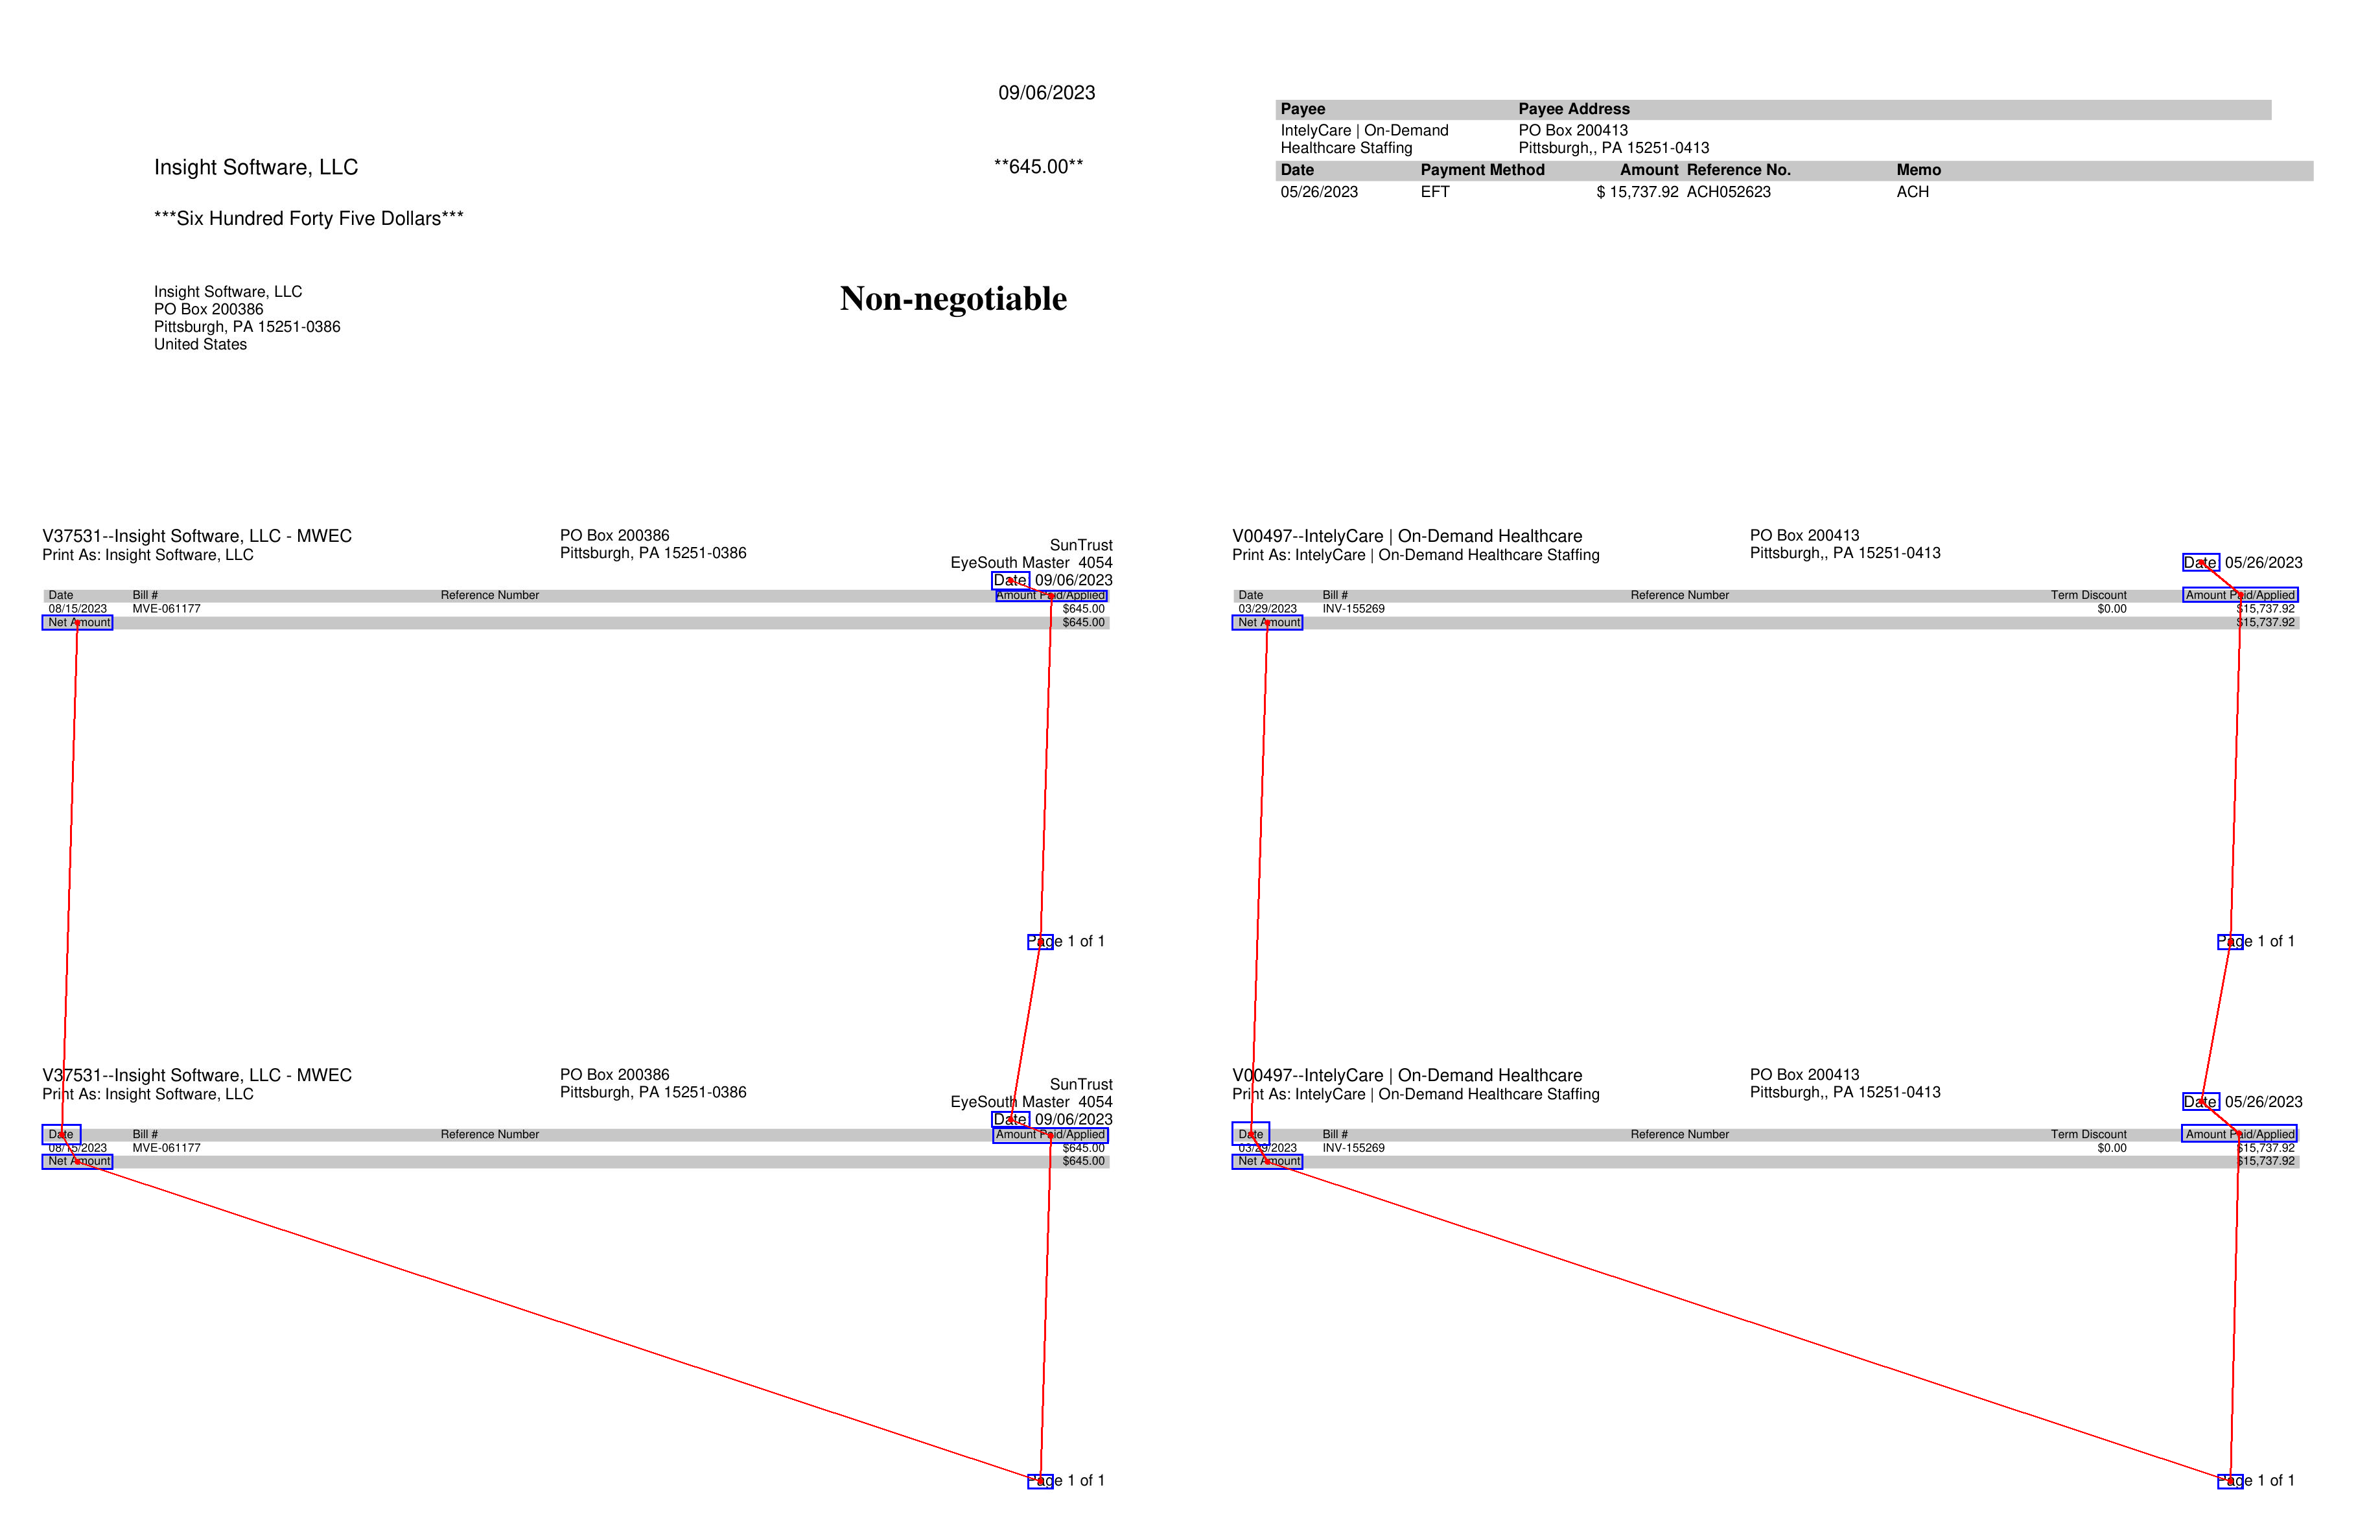

In [691]:
im_t = target_image.copy()
draw_graph(im_t, target_graph_matched,nodes=None)
im_s = source_image.copy()
draw_graph(im_s, source_graph_matched,nodes=None)
get_concat_h(im_s, im_t)

In [159]:
{
    'images_similarity_score': images_similarity_score,
    'images_similarity_count': images_similarity_count,
    'text_similarity_score': text_similarity_score
}

{'images_similarity_score': 0.52,
 'images_similarity_count': 16,
 'text_similarity_score': 0.31}